# Potencial tipo embudo 2D

El potencial está todavía por reajustar. Esto se hizo con apoyo del notebook Gaussian_kernel.

In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')

# Definición del sistema

In [3]:
system = mm.System()
mass   = 39.948 * unit.amu # masa del átomo Ar
system.addParticle(mass)

0

# Potencial tipo embudo 2D

### Pozo harmónico en Z

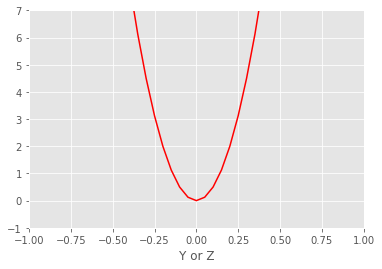

In [4]:
# '0.5*K*x**2'

def harmonic_well(x,K):
    return 0.5*K*x**2

K=100.0

x_serie = np.arange(-5., 5., 0.05)
plt.rcParams['figure.figsize'] = 6,4
plt.plot(x_serie, harmonic_well(x_serie,K), 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("Y or Z")
plt.show()

Calculamos el periodo de oscilación natural para tener referencia temporal para la elección del paso de integración. Igual que en los notebooks anteriores. Pero esta vez, como ya sabemos que en el caso del pozo harmónico k_effectiva=k

In [5]:
effective_k = K
T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
print('Periodo T de oscilación',T)

Periodo T de oscilación 0.19414738754194238 ps


### Potencial tipo embudo en 2D

In [10]:
def elliptical_gaussian_kernel_2D(x,y,xo,yo,A=-1.0,cxx=0.0,cxy=0.0,cyy=0.0):
    inc_x = x-xo
    inc_y = y-yo
    B = cxx*inc_x*inc_x + 2*cxy*inc_x*inc_y + cyy*inc_y*inc_y
    return A*np.exp(-B)

def check_positive_2d(embudo):
    pot_i=0
    for pot in embudo:
        xo, yo, A, cxx, cxy, cyy = pot
        M = np.array([[cxx, cxy],[cxy, cyy]])
        is_positive = np.all(np.linalg.eigvals(M+M.transpose()) > 0)
        if not is_positive:
            print('La gaussiana',pot_i, 'no es definida positiva')
        pot_i+=1

def effective_ks_2D(embudo):
    
    effective_ks = []
    pot_i = 0
    for pot in embudo:
        xo, yo, A, cxx, cxy, cyy = pot
        x = sy.symbols('x')
        y = sy.symbols('y')
        f = A*sy.exp(-(cxx*(x-xo)**2 + 2*cxy*(x-xo)*(y-yo) + cyy*(y-yo)**2))
        gradient = sy.derive_by_array(f,(x,y))
        hessian = sy.derive_by_array(gradient,(x,y))
        M = hessian.subs(x,xo).subs(y,yo)
        M = np.array(M.tolist(),dtype=float)
        eigenvals, eigenvecs = np.linalg.eig(np.array(M))
        #print('Gaussiana',pot_i)
        for ii in range(eigenvals.shape[0]):
            eff_k = eigenvals[ii]
            if eff_k > 0.0:
                effective_ks.append(eff_k)
            #print('\t effective k',eff_k,'en modo',eigenvecs[:,ii])
        pot_i+=1
        #print('')
    return np.max(effective_ks)

def plot_embudo_2D(embudo):
    
    xlim = [-8,8]
    ylim = [-8,8]
    xbins = 100
    ybins = 100

    x = np.linspace(xlim[0], xlim[1], xbins)
    y = np.linspace(ylim[0], ylim[1], ybins)

    X,Y = np.meshgrid(x, y)
    Z = 0.0
    for pot in embudo:
        xo, yo, A, cxx, cxy, cyy = pot
        Z += elliptical_gaussian_kernel_2D(X,Y,xo,yo,A,cxx,cxy,cyy)

    plt.rcParams['figure.figsize'] = 12, 12
    extent = [xlim[0], xlim[1], ylim[0], ylim[1]]
    #im = plt.imshow(Z, extent=extent, origin='lower',
    #                cmap=plt.cm.RdBu, interpolation='gaussian')

    cset = plt.contour(Z, np.arange(-4,0,0.1), extent=extent, origin='lower',
                       linewidths=1, cmap=plt.cm.Set1)

    plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
    #plt.colorbar(im, alpha=0.5)

    plt.show()

def plot_embudo_surface_2D(embudo):
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    xlim = [-8,8]
    ylim = [-8,8]
    xbins = 100
    ybins = 100

    x = np.linspace(xlim[0], xlim[1], xbins)
    y = np.linspace(ylim[0], ylim[1], ybins)

    X,Y = np.meshgrid(x, y)
    Z = 0.0
    for pot in embudo:
        xo, yo, A, cxx, cxy, cyy = pot
        Z += elliptical_gaussian_kernel_2D(X,Y,xo,yo,A,cxx,cxy,cyy)

    plt.rcParams['figure.figsize'] = 12, 12
    extent = [xlim[0], xlim[1], ylim[0], ylim[1]]
    
    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)

    ax.view_init(30, 45)
    
    plt.show()

def plot_embudo_mayavi_2D(embudo):
    
    xlim = [-8,8]
    ylim = [-8,8]
    xbins = 100
    ybins = 100

    x = np.linspace(xlim[0], xlim[1], xbins)
    y = np.linspace(ylim[0], ylim[1], ybins)

    X,Y = np.meshgrid(x, y)
    Z = 0.0
    for pot in embudo:
        xo, yo, A, cxx, cxy, cyy = pot
        Z += elliptical_gaussian_kernel_2D(X,Y,xo,yo,A,cxx,cxy,cyy)


    return mlab.surf(Z, warp_scale='auto')

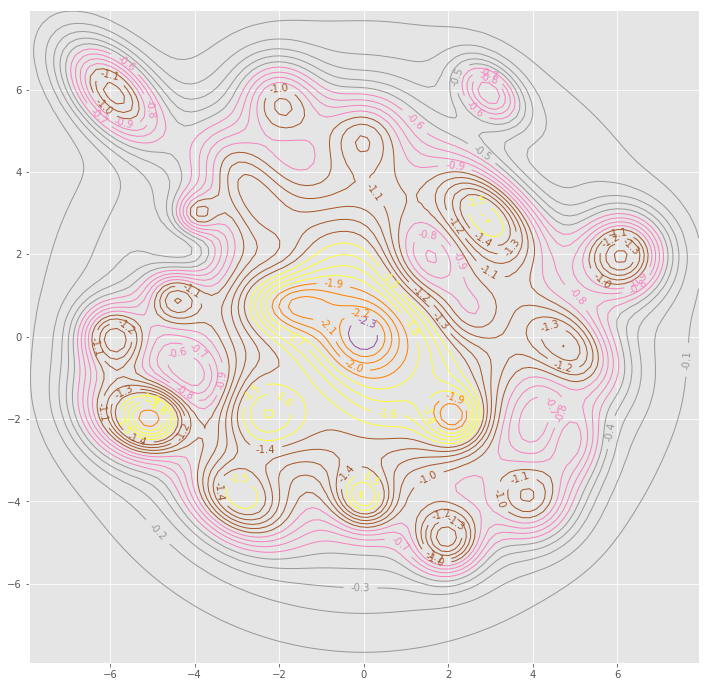

In [7]:
#pot_i = [xo, yo, A, cxx, cxy, cyy]
pot_0 =  [ 0.0,  0.0, -2.0, 0.05, 0.0, 0.05]
pot_1 =  [ 0.0,  0.0, -0.4,  2.0,  0.0, 2.0]
pot_2 =  [ 3.0,  3.0, -0.8,  1.0,  0.5, 1.0]
pot_3 =  [ 0.0,  5.0, -0.6,  1.0,  0.0, 1.0]
pot_4 =  [-2.5, -2.0, -0.5,  1.0,  0.0, 1.0]
pot_5 =  [ 2.2, -2.0, -0.8,  2.0,  0.0, 2.0]
pot_6 =  [ 3.0,  6.0, -0.8,  2.0,  0.8, 2.0]
pot_7 =  [-4.5,  1.0, -0.8,  2.0,  0.0, 2.0]
pot_8 =  [-3.0,  4.0, -0.6,  1.0,  0.4, 0.7]
pot_9 =  [ 0.0, -4.0, -0.8,  2.0,  0.2, 2.0]
pot_10 = [-2.0,  5.8, -0.8,  1.0,  0.1, 1.0]
pot_11 = [-1.8,  0.8, -0.5,  0.9,  0.0, 2.0]
pot_12 = [ 5.0, -0.3, -0.8,  1.0,  0.4, 1.0]
pot_13 = [ 4.0, -4.0, -0.8,  1.0,  0.0, 1.0]
pot_14 = [ 5.0, -2.5, -0.6,  2.0,  0.0, 1.0]
pot_15 = [-3.0, -4.0, -1.0,  0.8,  0.3, 1.0]
pot_16 = [-4.0,  3.0, -0.7,  3.5,  0.0, 3.5]
pot_17 = [-5.0, -2.0, -1.2,  1.5,  0.0, 1.5]
pot_18 = [-6.0, -1.8, -0.8,  1.0,  0.2, 0.8]
pot_19 = [ 2.0, -5.0, -1.0,  1.5,  0.0, 1.5]
pot_20 = [-6.0,  0.0, -1.0,  1.5,  0.1, 1.5]
pot_21 = [-6.0,  6.0, -1.2,  1.0,  0.5, 0.9]
pot_22 = [ 6.2,  2.0, -1.2,  1.0,  0.0, 1.0]

pot_23 = [-2.0,  2.0,  0.2, 1.5, 0.0, 1.5]
pot_24 = [ 1.5,  1.8,  0.8, 1.0, 0.2, 0.8]
pot_25 = [ 2.5,  0.5,  0.4, 1.5, 0.0, 1.5]
pot_26 = [-4.0, -1.0,  0.4, 1.2, 0.1, 1.5]
pot_27 = [-1.5, -1.0,  0.3, 0.7, 0.5, 0.9]
pot_28 = [-4.2,  2.0,  0.5, 1.2, 0.0, 0.8]
pot_29 = [ 4.0,  4.0,  0.2, 0.8, 0.5, 0.9]
pot_30 = [ 4.2, -2.0,  0.2, 1.0, 0.0, 1.0]

embudo = [pot_0, pot_1, pot_2, pot_3, pot_4, pot_5, pot_6, pot_7, pot_8, pot_9, 
         pot_10, pot_11, pot_12, pot_13, pot_14, pot_15, pot_16, pot_17, pot_18,
         pot_19, pot_20, pot_21, pot_22, pot_23, pot_24, pot_25, pot_26, pot_27,
         pot_28, pot_29, pot_30]

check_positive_2d(embudo)
plot_embudo_2D(embudo)

Calculamos el periodo de oscilación natural en lo mínimos de los kernel gaussianos usados para construir el potencial embudo. Tomamos la máxima k efectiva para tener referencia temporal para la elección del paso de integración.

In [11]:
effective_k = effective_ks_2D(embudo)
T = 2*np.pi*np.sqrt(mass/(effective_k * unit.kilocalories_per_mole/unit.angstrom**2))
print('Periodo T de oscilación',T)

Periodo T de oscilación 17.940285452981605


### Añadiendo el potencial al sistema

In [13]:
### Harmónico en eje Z

force = mm.CustomExternalForce('(K/2.0)*(z^2)')
force.addGlobalParameter('K', K * unit.kilocalories_per_mole/unit.angstrom**2)
force.addParticle(0, [])
system.addForce(force)

### Potencial tipo embudo en X e Y

gaussian_kernel = 'A*exp(-(cxx*(x-xo)^2+2.0*cxy*(x-xo)*(y-yo)+cyy*(y-yo)^2))'

for pot in embudo:
    xo, yo, A, cxx, cxy, cyy = pot
    force = mm.CustomExternalForce(gaussian_kernel)
    force.addGlobalParameter('A', A * unit.kilocalories_per_mole)
    force.addGlobalParameter('cxx', cxx * 1.0/unit.angstrom**2)
    force.addGlobalParameter('cxy', cxy * 1.0/unit.angstrom**2)
    force.addGlobalParameter('cyy', cyy * 1.0/unit.angstrom**2)
    force.addGlobalParameter('xo', xo * unit.angstrom)
    force.addGlobalParameter('yo', yo * unit.angstrom)
    force.addParticle(0, [])
    system.addForce(force)

# Estado termodinámico

In [14]:
# Formalismo NVT
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

# Parámetros de la simulación

In [15]:
step_size       = 0.01*unit.picoseconds
num_steps       = 4000000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

# Integrador

In [16]:
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Plataforma de simulación

In [17]:
platform_name = 'CPU'  #platform:     A platform (CPU, OpenCL, CUDA, or reference); default is platform=OpenCL"
# for ii in range(mm.Platform.getNumPlatforms()):
#     print(mm.Platform.getPlatform(ii).getName())
platform = mm.Platform.getPlatformByName(platform_name)

# Reporteros y arrays de salida

In [18]:
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

# Condiciones iniciales

In [19]:
initial_positions  = [[0.0, 0.0, 0.0]] * unit.angstroms
#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

In [20]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Corriendo la simulación

In [21]:
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 40000/40000 [20:40<00:00, 32.24it/s]


# Análisis de resultados

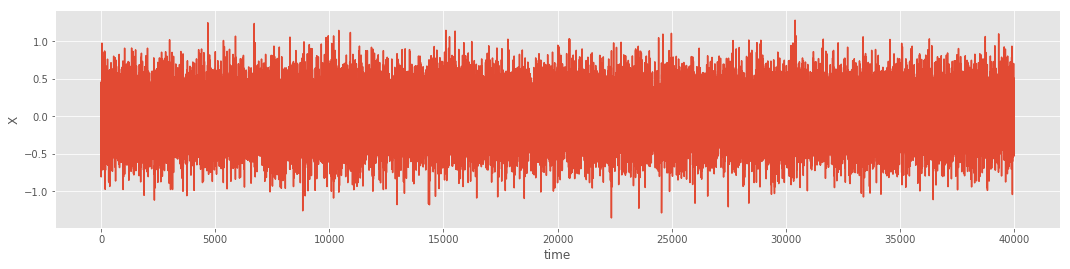

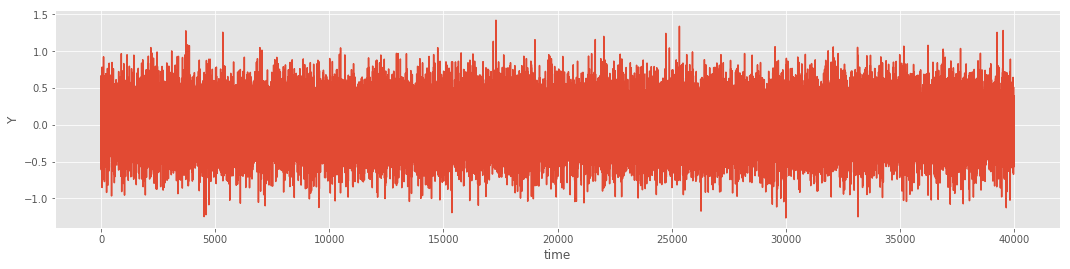

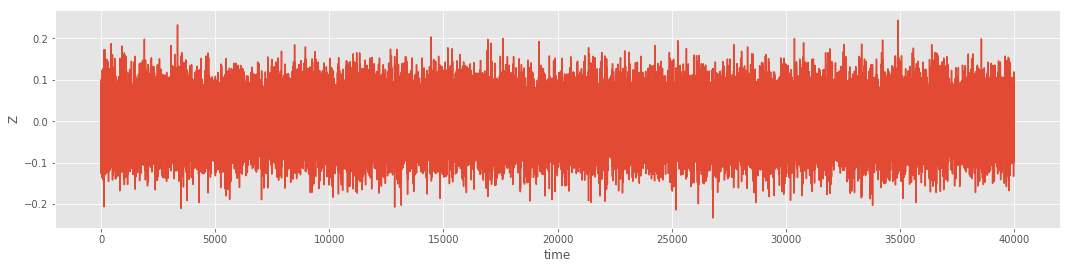

In [22]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

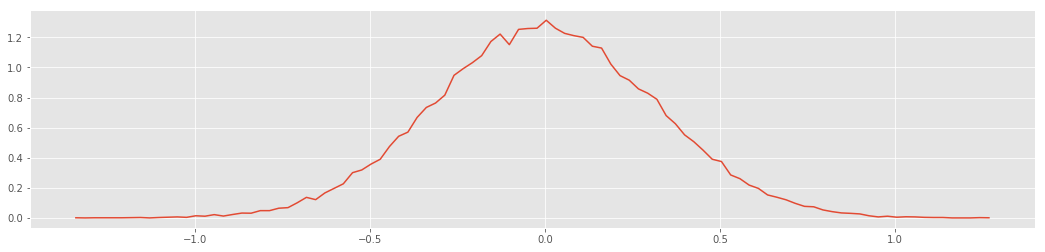

In [23]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

/home/diego/Myusr/opt/miniconda3/envs/academia/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


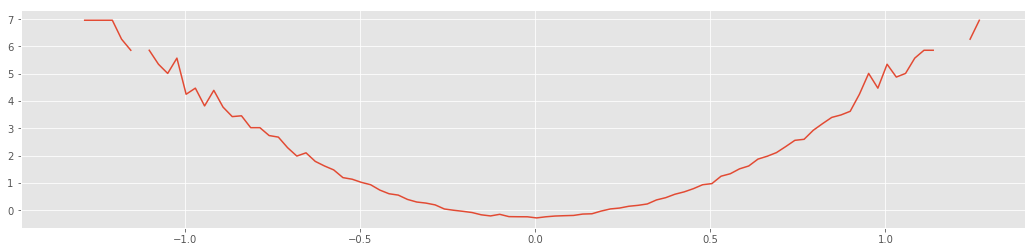

In [24]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
writing = False

if writing: 
    h5f = h5py.File('data_double_well_md.h5', 'w')
    h5f.create_dataset('times', data=times)
    h5f.create_dataset('positions', data=positions)
    h5f.create_dataset('velocities', data=velocities)
    h5f.create_dataset('kinetic_energies', data=kinetic_energies)
    h5f.create_dataset('potential_energies', data=potential_energies)
    h5f.close()

In [ ]:
reading =False

if reading:
    h5f = h5py.File('data_double_well_md.h5', 'r')
    #for name in h5f:
    #    print(name)
    times              = h5f['times'][:]
    positions          = h5f['positions'][:]
    velocities         = h5f['velocities'][:]
    kinetic_energies   = h5f['kinetic_energies'][:]
    potential_energies = h5f['potential_energies'][:]
    h5f.close()

In [ ]:
"""
T = sqrt(m/K)
timestep smaller than ~ T/10
standard deviation in each dimension sigma= (kT / K)^(1/2)
Expectation and standard deviation of the potential energy of a 3D harmonic oscillator is (3/2)kT
"""

### Todo:

- Los gaussian kernel son demasiado abiertos, la k efectiva es muy baja en comparación con el potencial del eje z